In [2]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [3]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.distributions.truncatednormal import TruncatedNormal
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction_for_coupled_momentum_model

from project_ssms.coupled_momentum_observation import CoupledMomentumObservation
from project_ssms.coupled_momentum_observation import CoupledMomemtumTransformation
from project_ssms.feature_funcs import feature_func_single
from project_ssms.momentum_utils import filter_traj_by_speed

import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

#from tqdm import trange
from tqdm import tqdm_notebook as tqdm

import time

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

ImportError: cannot import name 'k_step_prediction_for_coupled_momentum_model' from 'ssm_ptc.utils' (/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc/ssm_ptc/utils.py)

# data

In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

session_data = datasets_processed[0].render_trajectories([3,8])
traj0 = np.concatenate((session_data), axis=1)

In [4]:
del datasets_processed

In [5]:
del session_data

In [6]:
f_traj = filter_traj_by_speed(traj0, q1=0.99, q2=0.99)

In [7]:
arena_xmin = 10
arena_xmax = 320

arena_ymin = -10
arena_ymax = 390

WATER = torch.tensor([50, 50], dtype=torch.float64)
FOOD = torch.tensor([270, 50], dtype=torch.float64)
NEST = torch.tensor([270, 330], dtype=torch.float64)
CORNER = torch.tensor([50, 330], dtype=torch.float64)

# model

In [22]:
momentum_lags = 30
momentum_weights = np.arange(0.55, 2.05, 0.05)

In [20]:
torch.manual_seed(0)
np.random.seed(0)

bounds = np.array([[arena_xmin - 5, arena_xmax + 5], [arena_ymin - 5, arena_ymax + 5], 
                   [arena_xmin - 5, arena_xmax + 5], [arena_ymin - 5, arena_ymax + 5]])

max_v = np.array([5.0, 5.0, 5.0, 5.0])

acc_factor=2

K = 2
D = 4
Df = 10
T = 36000

observation = CoupledMomentumObservation(K=K, D=D, M=0, 
                                         momentum_lags=momentum_lags,momentum_weights=momentum_weights,
                                         Df=Df, feature_func=feature_func_single, bounds=bounds, 
                                         max_v=max_v, acc_factor=acc_factor)

model = HMM(K=K, D=D, M=0, observation=observation)
m_tran = model.observation.transformation

In [21]:
data = torch.tensor(f_traj, dtype=torch.float64)

In [55]:
momentum_vecs = CoupledMomemtumTransformation._compute_momentum_vecs(data[:-1],
                                                                     lags=momentum_lags, 
                                                                     weights=momentum_weights)
features = CoupledMomemtumTransformation._compute_features(m_tran.feature_funcs, data[:-1])

In [24]:
model.observation.mus_init = data[0] * torch.ones(K, D, dtype=torch.float64)

In [25]:
model.log_likelihood(data)

tensor(-490363.1064, dtype=torch.float64,
       grad_fn=<HMMNormalizerCythonBackward>)

# training

In [26]:
##################### training ############################

num_iters = 5000
losses, opt = model.fit(data, num_iters=num_iters, lr=0.005, momentum_vecs=momentum_vecs, features=features)

iter 4990 loss 221415.57: 100%|██████████| 5000/5000 [36:26<00:00,  2.34it/s] | 0/5000 [00:00<?, ?it/s]


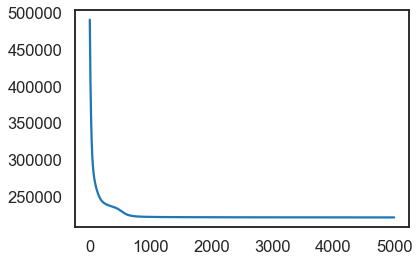

In [153]:
plt.plot(losses[0:])

In [27]:
z = model.most_likely_states(data)

In [28]:
x_predict = k_step_prediction_for_coupled_momentum_model(model, z, data, momentum_vecs=momentum_vecs, features=features)

([], <a list of 0 Text yticklabel objects>)

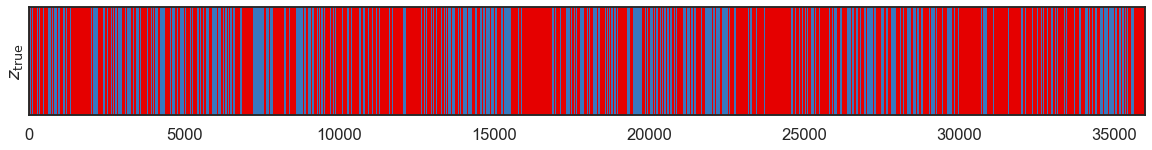

In [29]:
plt.figure(figsize=(20,2))
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

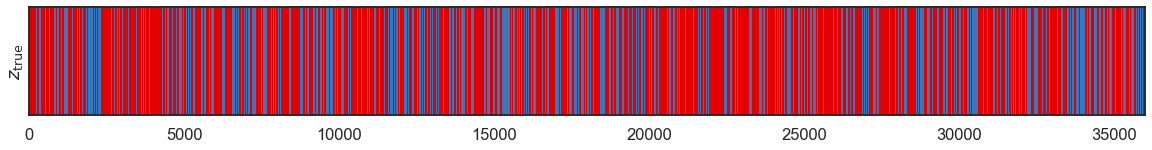

In [160]:
plt.figure(figsize=(20,2))
plt.imshow(sample_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

In [118]:
torch.exp(model.observation.log_sigmas)

tensor([[1.4474, 1.5855, 2.3979, 2.4163],
        [0.6837, 0.6558, 0.8225, 0.7713]], dtype=torch.float64,
       grad_fn=<ExpBackward>)

In [85]:
from project_ssms.plot_utils import plot_z

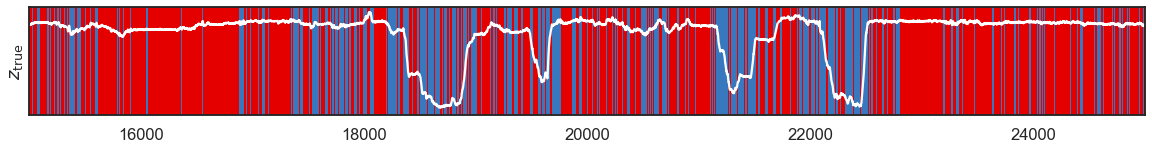

In [106]:
plot_z(z, plot_range=(15000,25000), ylim=(arena_xmin, arena_xmax))
plt.plot(data[:,0].numpy(), color='white')

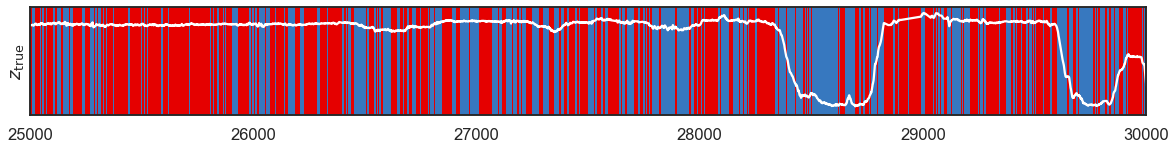

In [101]:
plot_z(z, plot_range=(25000,30000), ylim=(arena_xmin, arena_xmax))
plt.plot(data[:,0].numpy(), color='white')

red: z=1
blue: z=0

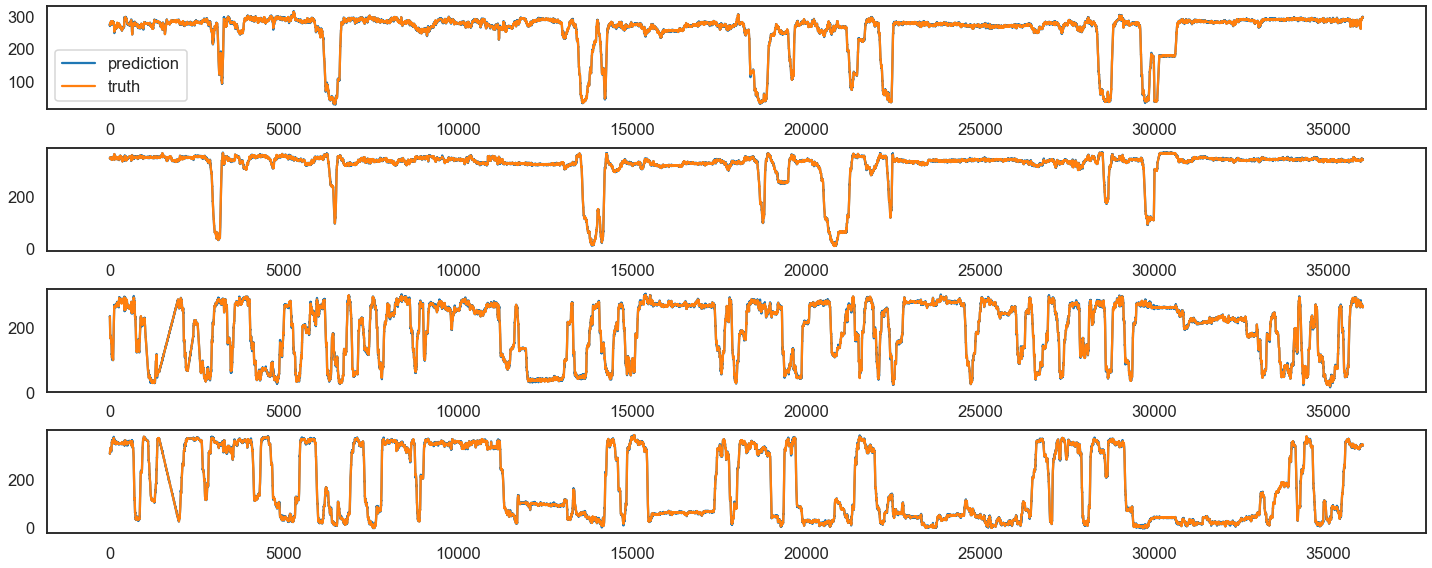

In [30]:
plt.figure(figsize=(20,8))

plt.subplot(4,1,1)
plt.plot(x_predict[:,0], label='prediction')
plt.plot(data[:,0].numpy(), label='truth')
plt.legend()

plt.subplot(4,1,2)
plt.plot(x_predict[:,1], label='prediction')
plt.plot(data[:,1].numpy(), label='truth')

plt.subplot(4,1,3)
plt.plot(x_predict[:,2], label='prediction')
plt.plot(data[:,2].numpy(), label='truth')

plt.subplot(4,1,4)
plt.plot(x_predict[:,3], label='prediction')
plt.plot(data[:,3].numpy(), label='truth')

plt.tight_layout()

In [1]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(f_traj[:,0], f_traj[:,1])
plt.title("real traj: virgin")

plt.subplot(1,2,2)
plt.plot(f_traj[:,2], f_traj[:,3])
plt.title("real traj: mother")

plt.tight_layout()

NameError: name 'plt' is not defined

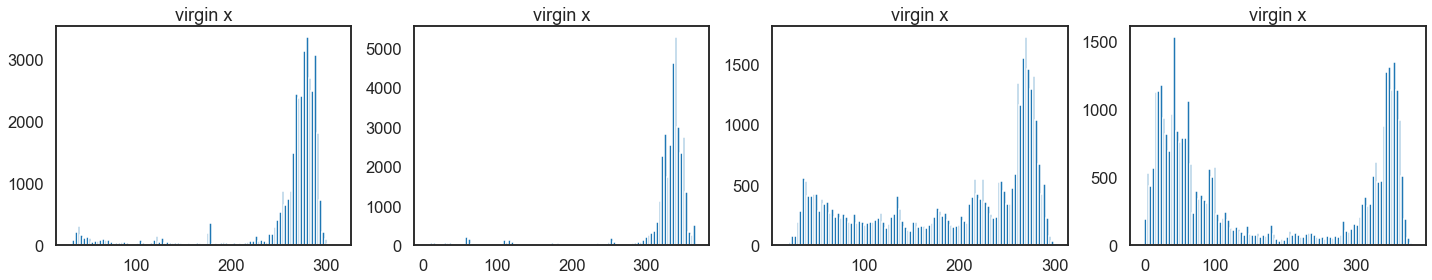

In [189]:
plt.figure(figsize=(20, 4))

plt.subplot(1,4,1)
plt.hist(f_traj[:,0], bins=100);
plt.title("virgin x")

plt.subplot(1,4,2)
plt.hist(f_traj[:,1], bins=100);
plt.title("virgin x")

plt.subplot(1,4,3)
plt.hist(f_traj[:,2], bins=100);
plt.title("virgin x")

plt.subplot(1,4,4)
plt.hist(f_traj[:,3], bins=100);
plt.title("virgin x")

plt.tight_layout()

(-1, 1)

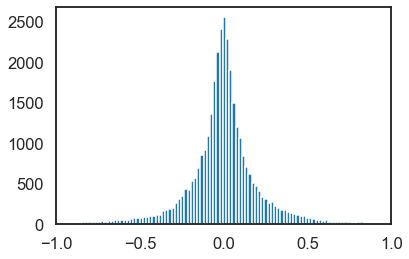

In [194]:
plt.hist(momentum_vecs[:,0], bins=500);
plt.xlim(-1,1)

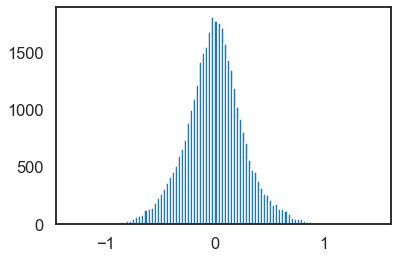

In [191]:
plt.hist(sample_momentum_vecs[:,0], bins=100);

In [31]:
z_num = [sum(z==k) for k in range(K)]
z_num

[13770, 22230]

# samples

In [37]:
z[0]

1

In [156]:
model.observation.mus_init =torch.tensor([60, 50, 60, 50], dtype=torch.float)

In [157]:
sample_z, sample_x = model.sample(T)

In [158]:
[sum(sample_z == k) for k in range(K)]

[14079, 21921]

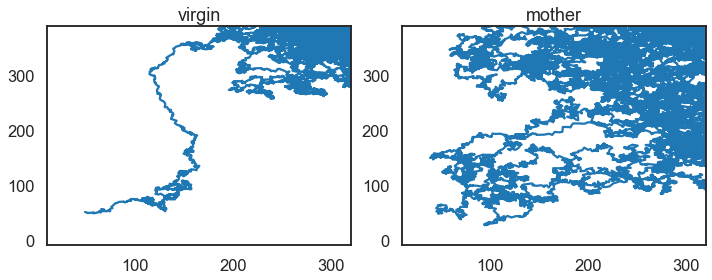

In [159]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(sample_x[:,0], sample_x[:,1])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)
plt.title("virgin")
plt.subplot(1,2,2)
plt.plot(sample_x[:,2], sample_x[:,3])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)
plt.title("mother")

plt.tight_layout()

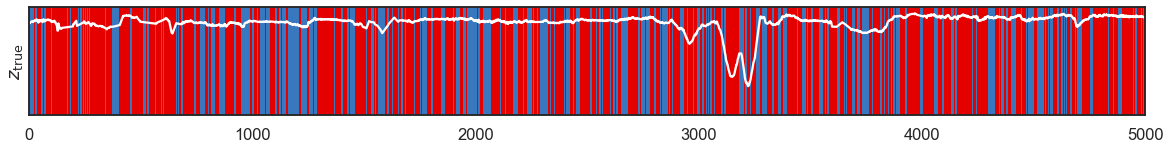

In [178]:
plot_z(sample_z, plot_range=(0,5000), ylim=(arena_xmin, arena_xmax))
plt.plot(data[0:5000,0].numpy(), color='white')

(-10, 390)

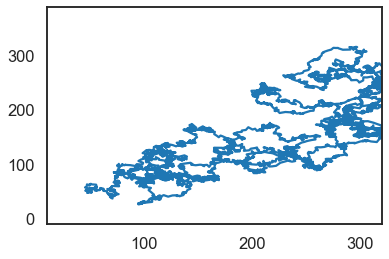

In [168]:
plt.plot(sample_x[:6000,2], sample_x[:6000,3])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)

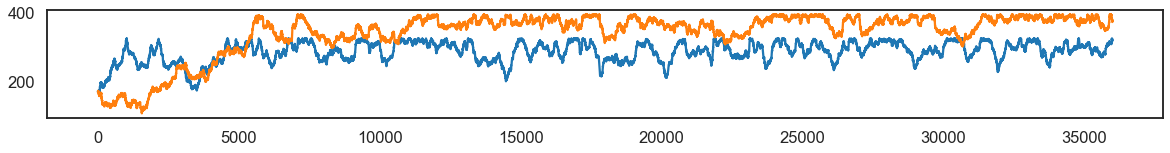

In [49]:
plt.figure(figsize=(20,2))
plt.plot(sample_x[:,0])
plt.plot(sample_x[:,1])

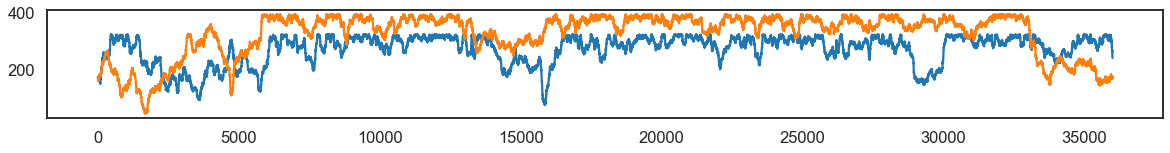

In [151]:
plt.figure(figsize=(20,2))
plt.plot(sample_x[:,2])
plt.plot(sample_x[:,3])

In [56]:
sample_momentum_vecs = CoupledMomemtumTransformation._compute_momentum_vecs(torch.tensor(sample_x[:-1], dtype=torch.float64),
                                                                     lags=momentum_lags, 
                                                                     weights=momentum_weights)

# dynamics

#### 1. Condition on fix z sequence (say z = [1,1,1,....,1,1,]), see how the sampled observations look like.

In [135]:
fix_t = 5000
fix_z0 = np.zeros(fix_t)
fix_z1 = np.ones(fix_t)

In [163]:
sample_z0 = model.sample_condition_on_zs(zs=fix_z0, x0=data[0])
sample_z1 = model.sample_condition_on_zs(zs=fix_z1, x0=data[0])


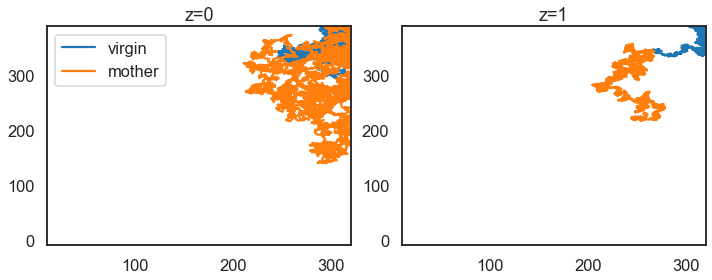

In [155]:
plt.figure(figsize=(10, 4))

ax1 = plt.subplot(1,2,1)
plt.plot(sample_z0[:,0], sample_z0[:,1], label='virgin')
plt.plot(sample_z0[:,2], sample_z0[:,3], label='mother')
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)
plt.legend()
ax1.set_title("z=0")

ax2 = plt.subplot(1,2,2)
plt.plot(sample_z1[:,0], sample_z1[:,1])
plt.plot(sample_z1[:,2], sample_z1[:,3])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)
ax2.set_title("z=1")

plt.tight_layout()

#### 2. quiverplots

In [197]:
bounds

array([[  5, 325],
       [-15, 395],
       [  5, 325],
       [-15, 395]])

In [199]:
XX, YY = np.meshgrid(np.linspace(0, 325, 30), 
                     np.linspace(-15, 395, 30))
XY = np.column_stack((np.ravel(XX), np.ravel(YY))) # shape (900,2) grid values

In [200]:
def get_XY_other(pos, shape=(900,1)):
    return np.tile(pos[None,], shape)

In [201]:
def get_quiver_args(other_pos, momentum_vec):
    quiver_momentum_vecs = momentum_vec * torch.ones(900, 1, dtype=torch.float64)
    XY_other = get_XY_other(other_pos)
    XY_virgin = np.concatenate((XY, XY_other), axis=1)
    XY_mother = np.concatenate((XY_other, XY), axis=1)
    
    XY_virgin_next = m_tran.transform(torch.tensor(XY_virgin, dtype=torch.float64), momentum_vecs=quiver_momentum_vecs)
    dXY_virgin = XY_virgin_next.detach().numpy() - XY_virgin[:, None]
    
    XY_mother_next = m_tran.transform(torch.tensor(XY_mother, dtype=torch.float64), momentum_vecs=quiver_momentum_vecs)
    dXY_mother = XY_mother_next.detach().numpy() - XY_mother[:, None]
    
    return XY_virgin, dXY_virgin, XY_mother, dXY_mother

In [202]:
momentum_vec_0 = torch.tensor([-1, -1, 0, 0], dtype=torch.float64) # (4, )
momentum_vec_1 = torch.tensor([1, 1, 0, 0], dtype=torch.float64) # (4, )
momentum_vec_2 = torch.tensor([0.02, -0.02, 0, 0], dtype=torch.float64) # (4, )

In [203]:
XY_virgin_water, dXY_virgin_water_0, XY_mother_water, dXY_mother_water_0 = get_quiver_args(WATER, momentum_vec_0)                                                                            
XY_virgin_water, dXY_virgin_water_1, XY_mother_water, dXY_mother_water_1 = get_quiver_args(WATER, momentum_vec_1)                                                                            
XY_virgin_water, dXY_virgin_water_2, XY_mother_water, dXY_mother_water_2 = get_quiver_args(WATER, momentum_vec_2)                                                                            
XY_virgin_nest, dXY_virgin_nest_2, XY_mother_nest, dXY_mother_nest_2 = get_quiver_args(NEST, momentum_vec_2) 
XY_virgin_nest, dXY_virgin_nest_0, XY_mother_nest, dXY_mother_nest_0 = get_quiver_args(NEST, momentum_vec_0)
XY_virgin_nest, dXY_virgin_nest_1, XY_mother_nest, dXY_mother_nest_1 = get_quiver_args(NEST, momentum_vec_1)

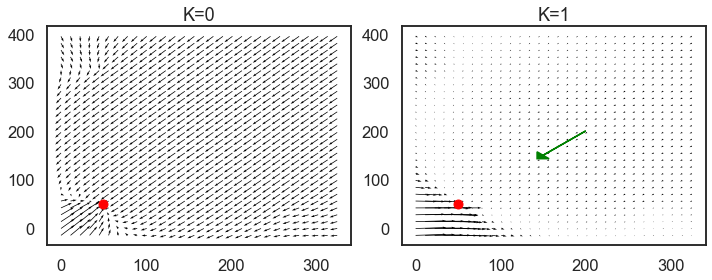

In [204]:
plot_quiver(XY_virgin_water, dXY_virgin_water_0, 'virgin', WATER, scale=0.1)
plt.arrow(200, 200, -50, -50, color='green', head_length = 10, head_width = 20);

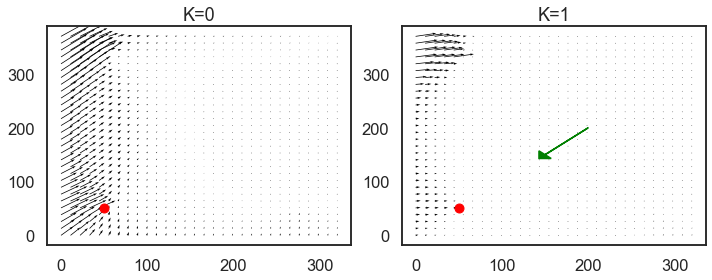

In [174]:
plot_quiver(XY_mother_water, dXY_mother_water_0, 'mother', WATER, scale=0.1)
plt.arrow(200, 200, -50, -50, color='green', head_length = 10, head_width = 20);

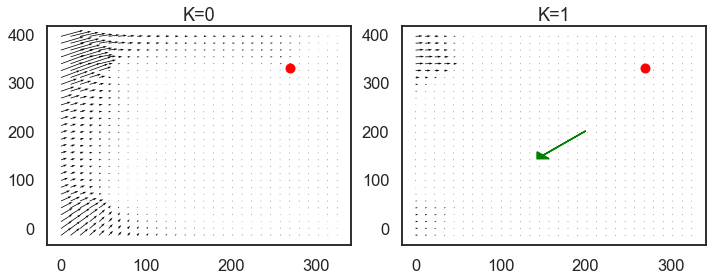

In [205]:
plot_quiver(XY_mother_nest, dXY_mother_nest_0, 'mother', NEST, scale=0.1)
plt.arrow(200, 200, -50, -50, color='green', head_length = 10, head_width = 20);

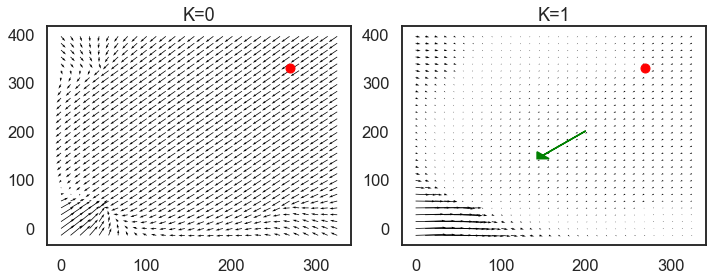

In [206]:
plot_quiver(XY_virgin_nest, dXY_virgin_nest_0, 'virgin', NEST, scale=0.1)
plt.arrow(200, 200, -50, -50, color='green', head_length = 10, head_width = 20);

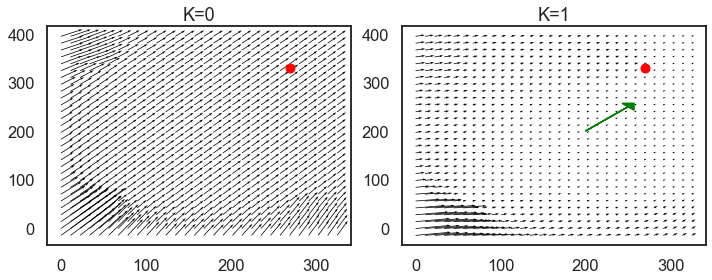

In [207]:
plot_quiver(XY_virgin_nest, dXY_virgin_nest_1, 'virgin', NEST, scale=0.1)
plt.arrow(200, 200, 50, 50, color='green', head_length = 10, head_width = 20);

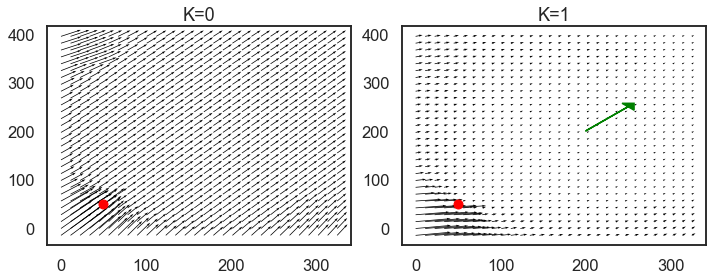

In [208]:
plot_quiver(XY_virgin_water, dXY_virgin_water_1, 'virgin', WATER, scale=0.1)
plt.arrow(200, 200, 50, 50, color='green', head_length = 10, head_width = 20);

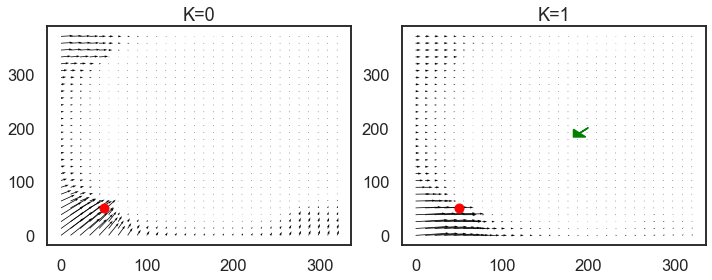

In [115]:
plot_quiver(XY_virgin_water, dXY_virgin_water_2, 'virgin', WATER, scale=0.1)
plt.arrow(200, 200, -10, -10, color='green', head_length = 10, head_width = 20);

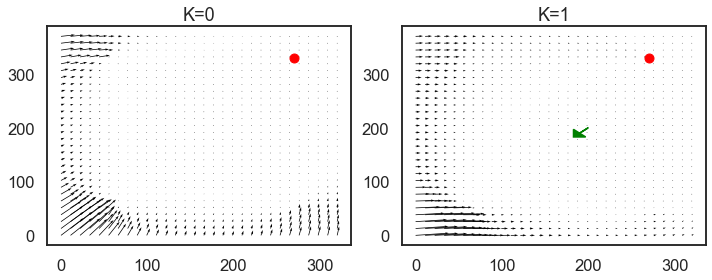

In [117]:
plot_quiver(XY_virgin_nest, dXY_virgin_nest_2, 'virgin', NEST, scale=0.1)
plt.arrow(200, 200, -10, -10, color='green', head_length = 10, head_width = 20);

In [80]:
torch.sigmoid(m_tran.alpha)

tensor([[0.5058, 0.6065, 0.5720, 0.6313],
        [0.1332, 0.1120, 0.1111, 0.1109]], dtype=torch.float64,
       grad_fn=<SigmoidBackward>)

## examine the dynamics introduced by features

In [120]:
m_tran.Ws.shape

torch.Size([2, 4, 10])

In [122]:
m_tran.Ws[0][:2].shape

torch.Size([2, 10])

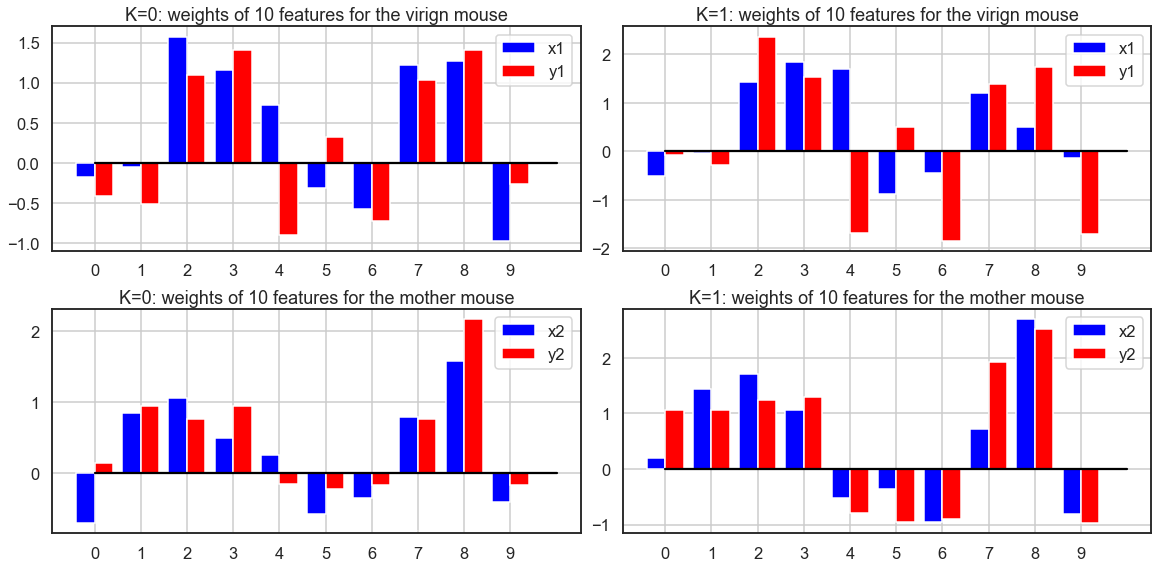

In [134]:
plt.figure(figsize=(16, 8))

plt.subplot(2,2,1)
plt.bar(np.arange(10) - 0.2, m_tran.Ws[0][0].detach().numpy(), width=.4, color='b', label='x1')
plt.bar(np.arange(10) + 0.2, m_tran.Ws[0][1].detach().numpy(), width=.4, color='r', label='y1')
plt.plot([0, 10], [0, 0], '-k')
plt.xticks(np.arange(0,10,1))
plt.grid()
plt.legend()
plt.title("K=0: weights of 10 features for the virign mouse")

plt.subplot(2,2,2)
plt.bar(np.arange(10) - 0.2, m_tran.Ws[1][0].detach().numpy(), width=.4, color='b', label='x1')
plt.bar(np.arange(10) + 0.2, m_tran.Ws[1][1].detach().numpy(), width=.4, color='r', label='y1')
plt.plot([0, 10], [0, 0], '-k')
plt.xticks(np.arange(0,10,1))
plt.grid()
plt.legend()
plt.title("K=1: weights of 10 features for the virign mouse")

plt.subplot(2,2,3)
plt.bar(np.arange(10) - 0.2, m_tran.Ws[0][2].detach().numpy(), width=.4, color='b', label='x2')
plt.bar(np.arange(10) + 0.2, m_tran.Ws[0][3].detach().numpy(), width=.4, color='r', label='y2')
plt.plot([0, 10], [0, 0], '-k')
plt.xticks(np.arange(0,10,1))
plt.grid()
plt.legend()
plt.title("K=0: weights of 10 features for the mother mouse")

plt.subplot(2,2,4)
plt.bar(np.arange(10) - 0.2, m_tran.Ws[1][2].detach().numpy(), width=.4, color='b', label='x2')
plt.bar(np.arange(10) + 0.2, m_tran.Ws[1][3].detach().numpy(), width=.4, color='r', label='y2')
plt.plot([0, 10], [0, 0], '-k')
plt.xticks(np.arange(0,10,1))
plt.grid()
plt.legend()
plt.title("K=1: weights of 10 features for the mother mouse")

plt.tight_layout()

PS. actually there are 5 features but each feature is 2-dimensional.

Comments:

Note that there are 10 features, where the first two features depend on the position of the other mouse (the unit vector pointing from this mouse to the other mouse), and the rest features depend on the relative position of self to the four corners of the arena.

From the weight matrices plot, we could see that

1) the features introduced by the othher mouse do not weight much
   - only 1 out of 5 feature depends on the other mouse
   - only the directional infromation is known

2) different states seem to have little influence on the weight matrices.

Furthemore, combining with the quiver plots, we could see that the dynamics are mostly dominant by the momentum vector, and less sensitive to the other mouse.

Reflection:

1) give more access to the other mouse's information, e.g. try $Wx+b$ instead of $Wf(x)+b$

2) lessen the influence of the momentum vector.

In [138]:
torch.exp(model.observation.log_sigmas)

tensor([[1.4474, 1.5855, 2.3979, 2.4163],
        [0.6837, 0.6558, 0.8225, 0.7713]], dtype=torch.float64,
       grad_fn=<ExpBackward>)

For the state where the dynamics is sensitive to momentum vector, the variance is higher. This is probably because the model needs additional noise to explain the behavior in a sharp change in the direction.

For example, when the mouse is darting to the wall, after it hits the wall, it would make a sharp change in the direction.

In [139]:
m_tran.bs.shape

torch.Size([2, 4])

In [140]:
m_tran.bs

tensor([[-1.1024, -0.9246, -1.2831, -1.0177],
        [-1.5574, -1.7645, -1.6708, -1.7337]], dtype=torch.float64,
       requires_grad=True)

In [141]:
from project_ssms.plot_utils import plot_2_mice, plot_4_traces